<a href="https://colab.research.google.com/github/YosukeSugiura/SougouEnshu-A/blob/master/kadai_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# バイナリマスクを用いた音源分離

ここではバイナリマスクを用いた音源分離を実装しましょう．

---

必要なモジュールをインストール & インポートします．

In [2]:
!pip install japanize-matplotlib -U

     |████████████████████████████████| 4.1 MB 30.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=f96096ff42d4d426225e3ec8260b6669cb5a7298dc79c37bd97242becd577443
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [3]:
import numpy as np
import scipy.signal as sg       # 信号処理モジュール
import soundfile as sf          # wavファイルを扱う際のモジュール
import IPython.display as disp  # iPython上でファイルを扱うためのモジュール
import urllib.request           # ファイルを読み込むためのモジュール
import matplotlib.pyplot as plt # 図を表示させるためのモジュール
import japanize_matplotlib      # 日本語を扱うためのモジュール

## 0. 音声の読み込みと確認
音声ファイルの読み込みを行います．音声ファイルは，ステレオマイクで収録された音声である．左右のチャンネルの音声を読み込み，それぞれ x_l，x_r とします．

また，音声信号の各サンプルに対応する時刻[s]をもった配列として t を作成します．

In [4]:
# wavファイルをGoogle colabのワークスペースにもってくる
urllib.request.urlretrieve('https://raw.githubusercontent.com/Shimamura-Lab-SU/Sharing-Knowledge-Database/master/python_exercise/stereo.wav', 'stereo.wav')
# wavファイルの読み込み
wav_data, fs = sf.read('stereo.wav')  # 戻り値：データ, サンプリング周波数
x_l = wav_data[:,0] # 左チャンネル信号
x_r = wav_data[:,1] # 右チャンネル信号
t = np.arange(len(x_l))/fs # 各サンプルの時刻(波形の図示で使う)

音声波形を図で確認します．

Text(0.5, -0.4, '音声波形(上段：左チャンネル，下段：右チャンネル)')

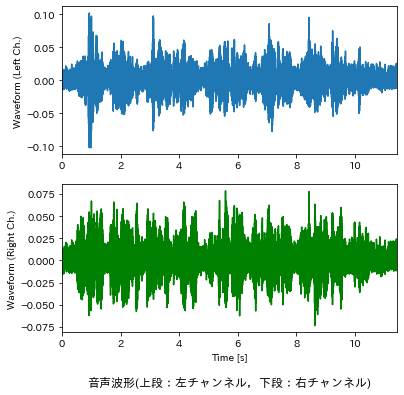

In [6]:
fig1 = plt.figure(num=1, figsize=(6,6))

# 複数のグラフを作成
ax1 = fig1.add_subplot(211) # 上段のグラフを作成
ax2 = fig1.add_subplot(212) # 下段のグラフを作成

# 各グラフをプロット
ax1.plot(t, x_l)
ax2.plot(t, x_r, color='g')

# 軸名・範囲の設定
ax1.set_xlim([t[0], t[-1]])
ax2.set_xlim([t[0], t[-1]])
ax1.set_ylabel("Waveform (Left Ch.)")
ax2.set_ylabel("Waveform (Right Ch.)")
ax2.set_xlabel("Time [s]")
plt.title("音声波形(上段：左チャンネル，下段：右チャンネル)", y=-0.4)

音声を聞くこともできます(イヤホン推奨)．
左右のチャンネルで，話者ごとの音量が異なることがわかります．

In [7]:
print('ステレオ音声')
disp.Audio(wav_data.T, rate = fs)

ステレオ音声


In [8]:
print('左チャンネルの音声')
disp.Audio(x_l, rate = fs)

左チャンネルの音声


In [9]:
print('右チャンネルの音声')
disp.Audio(x_r, rate = fs)

右チャンネルの音声


## 1. 音声のSTFT

音声をフレームごとに分割して，短時間フーリエ変換(STFT)を行います．
関数`sg.stft`を用いれば，フレーム分割・窓関数・STFTもすべて一括で行ってくれます．
STFT後の周波数スペクトログラムは，左右チャンネルごとにそれぞれ X_l，X_r に保存します．

ここではフレーム長を1024サンプル，シフト長を512サンプルに設定しています．
このとき，隣り合うフレームとの重複サンプル数(=オーバーラップ幅)は 1024-512=512サンプルになります．

In [10]:
# セグメント長，シフト長の指定
n_seg = 1024
n_shift = 512

# 各チャンネルごとに短時間フーリエ変換
f, t, X_l = sg.stft(x_l, fs=fs, nperseg=n_seg, noverlap=n_seg-n_shift) # 左チャンネル
_, _, X_r = sg.stft(x_r, fs=fs, nperseg=n_seg, noverlap=n_seg-n_shift) # 右チャンネル

各チャンネルの音声のスペクトログラムを図で確認します．ここでは音声の特徴が見やすいように，0Hz～2kHzまでを表示しています．

Text(0.5, -0.4, '音声のスペクトログラム(上段：左チャンネル，下段：右チャンネル)')

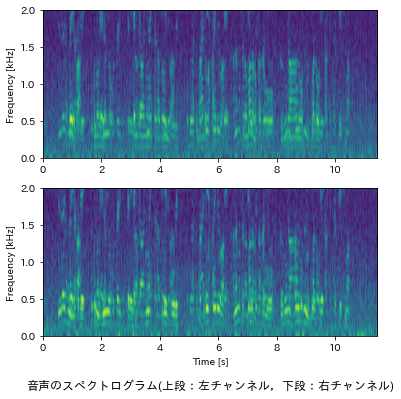

In [12]:
# パワースペクトログラムの計算
S_l = 10*np.log10(np.abs(X_l)**2+10**(-8))  # dB単位
S_r = 10*np.log10(np.abs(X_r)**2+10**(-8)) # dB単位

# 図の用意
fig2 = plt.figure(num=2, figsize=(6,6))

# 複数のグラフを作成
ax1 = fig2.add_subplot(211) # 上段のグラフを作成
ax2 = fig2.add_subplot(212) # 下段のグラフを作成

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000]
ax1.imshow(S_l, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)
ax2.imshow(S_r, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲の設定
ax1.set_ylim([0,2]) # 0~2kHzまでを表示
ax2.set_ylim([0,2])
ax1.set_ylabel("Frequency [kHz]")
ax2.set_ylabel("Frequency [kHz]")
ax2.set_xlabel("Time [s]")
plt.title("音声のスペクトログラム(上段：左チャンネル，下段：右チャンネル)", y=-0.4)

## 2. バイナリマスキング

スペクトログラムにバイナリマスクをかけてフィルタリングを行いましょう．
教科書をよく読み，バイナリマスクを実装しましょう．


In [13]:
# マスクの作成

#↓↓ ここに音源分離を実現するマスクを作成しよう！
#     このサンプルコードでは，マスクのすべての値を1(=すべての周波数成分をそのまま通過させる)にしています．
#     自身で書き換えて，音源分離を実装しましょう．
#--------------------------------------
# - 左チャンネル
G_l = np.ones(X_l.shape)  # すべての周波数成分でマスクの値を 1 に
# - 右チャンネル
G_r = np.ones(X_r.shape)  # すべての周波数成分でマスクの値を 1 に
#--------------------------------------
#↑↑ここまで

# スペクトログラムをマスキング
Y_l = G_l * X_l
Y_r = G_r * X_r

処理後の音声のスペクトログラムを確認しましょう．

(このサンプルコードは，入力音声をそのまま出力するフィルタリングを行っています．したがってオリジナルのままでは，入力音声と同じスペクトログラムが得られます．)

Text(0.5, -0.4, '処理音声のスペクトログラム(上段：左チャンネル，下段：右チャンネル)')

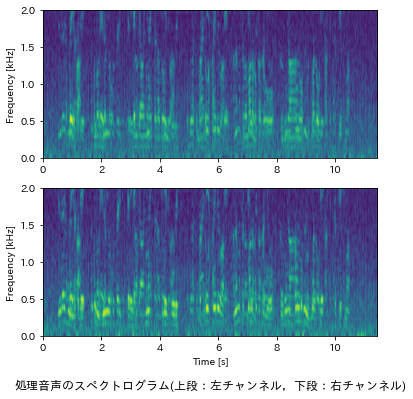

In [14]:
# パワースペクトログラムの計算
S_l = 10*np.log10(np.abs(Y_l)**2+10**(-8))  # dB単位
S_r = 10*np.log10(np.abs(Y_r)**2+10**(-8))  # dB単位

# 図の用意
fig3 = plt.figure(num=2, figsize=(6,6))

# 複数のグラフを作成
ax1 = fig3.add_subplot(211) # 上段のグラフを作成
ax2 = fig3.add_subplot(212) # 下段のグラフを作成

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000]
ax1.imshow(S_l, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)
ax2.imshow(S_r, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲の設定
ax1.set_ylim([0,2]) # 0~2kHzまでを表示
ax2.set_ylim([0,2])
ax1.set_ylabel("Frequency [kHz]")
ax2.set_ylabel("Frequency [kHz]")
ax2.set_xlabel("Time [s]")
plt.title("処理音声のスペクトログラム(上段：左チャンネル，下段：右チャンネル)", y=-0.4)

## 3. ISTFTによる音声波形の復元

処理音声に対して逆短時間フーリエ変換(Inverse Short Fourier Transform:ISTFT)を行い，音声波形を復元します．関数`sg.istft`を用いれば，オーバーラップアドも同時に行ってくれます．



In [15]:
# 各チャンネルごとに短時間フーリエ変換
t, y_l = sg.istft(Y_l, fs=fs, nperseg=n_seg, noverlap=n_seg-n_shift) # 戻り値：時刻，周波数スペクトル
_, y_r = sg.istft(Y_r, fs=fs, nperseg=n_seg, noverlap=n_seg-n_shift)

音声波形を確認します．

Text(0.5, -0.4, '処理音声波形(上段：左チャンネル，下段：右チャンネル)')

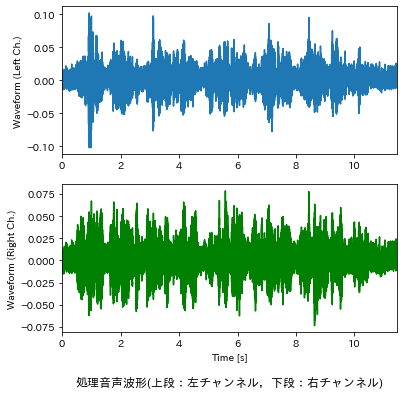

In [16]:
fig4 = plt.figure(num=1, figsize=(6,6))

# 複数のグラフを作成
ax1 = fig4.add_subplot(211) # 上段のグラフを作成
ax2 = fig4.add_subplot(212) # 下段のグラフを作成

# 各グラフをプロット
ax1.plot(t, y_l)
ax2.plot(t, y_r, color='g')

# 軸名・範囲の設定
ax1.set_xlim([t[0], t[-1]])
ax2.set_xlim([t[0], t[-1]])
ax1.set_ylabel("Waveform (Left Ch.)")
ax2.set_ylabel("Waveform (Right Ch.)")
ax2.set_xlabel("Time [s]")
plt.title("処理音声波形(上段：左チャンネル，下段：右チャンネル)", y=-0.4)

処理音声を聞いて音源が分離できていることを確認します．

In [17]:
print('左チャンネルの処理音声')
disp.Audio(y_l, rate = fs)

左チャンネルの処理音声


In [18]:
print('右チャンネルの処理音声')
disp.Audio(y_r, rate = fs)

右チャンネルの処理音声


以下のコードで処理音声のwavファイルをダウンロードできます．

In [19]:
sf.write('processed_sound_left.wav', y_l, fs) 
sf.write('processed_sound_right.wav', y_r, fs) 

from google.colab import files
files.download('processed_sound_left.wav')
files.download('processed_sound_right.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>